# RQ3: How can we visualize the relationship between income and food affordability by region?

To answer this quesiton, I'll be looking into an interaction model using affordability_ratio ~ median_income x region_name

Assumptions and Limitations for this question:
I'll be fitting an OLS interaction model that tests if median income and affordability ratio's relationship differs by region. Since this is an obersvational and aggregated dataset, the results I get will be descriptive based on the data and not causal. Also, since this dataset is aggregated, the results I get could be more smoothed and have less variation than if I had a bunch of much mroe raw data.

OLS assumes independent observations, linear relationship, and homoskedasticity. Because the affordability ratio is right-skewed as mentioned before and the model may not extrapolate well, I restricted the interaction plot to the smaller range as described in the code below, which is 5th to 95th percentile.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
DATA_PATH = Path("./data/food_affordability.csv")
OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

df_2 = pd.read_csv(DATA_PATH)
df_2.head()

# For preprocessing, I only kept the top 6 regions. I did the same with the getting rid of large outliers as RQ2.
df_rq3 = df_2[["affordability_ratio", "median_income", "region_name"]].dropna().copy()
upper = df_rq3["affordability_ratio"].quantile(0.99)
df_rq3 = df_rq3[df_rq3["affordability_ratio"] <= upper].copy()
df_rq3["income_c"] = df_rq3["median_income"] - df_rq3["median_income"].mean()
TOP_N = 6
top_regions = df_rq3["region_name"].value_counts().head(TOP_N).index
df_rq3_plot = df_rq3[df_rq3["region_name"].isin(top_regions)].copy()

df_rq3_plot["region_name"] = df_rq3_plot["region_name"].astype("category")


model_int = smf.ols(
    "affordability_ratio ~ income_c * C(region_name)",
    data=df_rq3_plot
).fit()

print(model_int.summary())

                             OLS Regression Results                            
Dep. Variable:     affordability_ratio   R-squared:                       0.356
Model:                             OLS   Adj. R-squared:                  0.353
Method:                  Least Squares   F-statistic:                     145.6
Date:                 Mon, 15 Dec 2025   Prob (F-statistic):          4.04e-267
Time:                         23:52:55   Log-Likelihood:                -226.69
No. Observations:                 2912   AIC:                             477.4
Df Residuals:                     2900   BIC:                             549.1
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

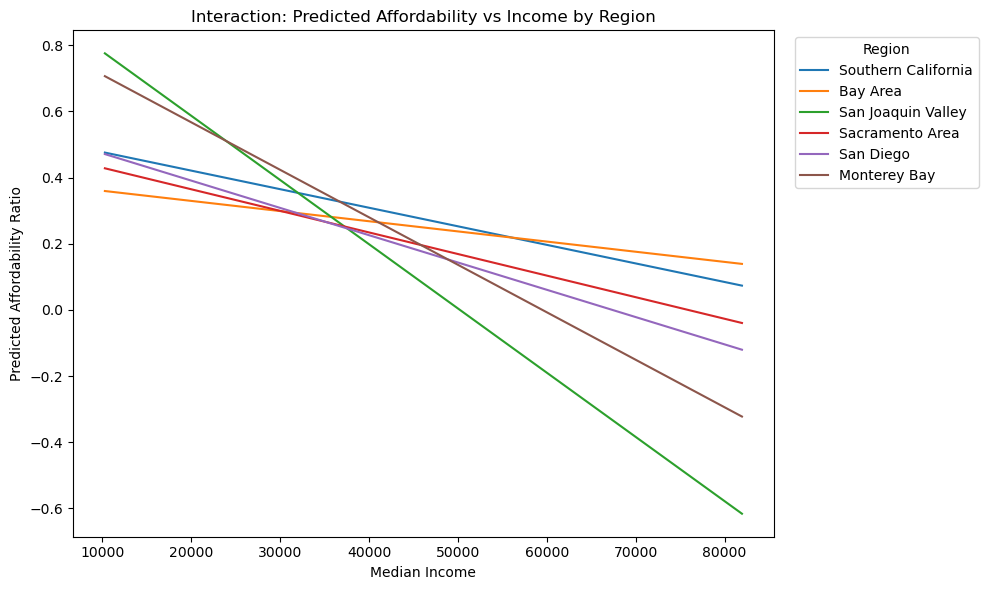

In [2]:
low, high = df_rq3_plot["median_income"].quantile([0.05, 0.95])
income_grid_raw = np.linspace(low, high, 100)

income_grid = income_grid_raw - df_rq3_plot["median_income"].mean()
pred_frames = []
for r in top_regions:
    tmp = pd.DataFrame({
        "income_c": income_grid,
        "region_name": r
    })
    tmp["pred_affordability"] = model_int.predict(tmp)
    pred_frames.append(tmp)

pred_df = pd.concat(pred_frames, ignore_index=True)
plt.figure(figsize=(10, 6))
for r in top_regions:
    sub = pred_df[pred_df["region_name"] == r]
    plt.plot(income_grid_raw, sub["pred_affordability"], label=r)
plt.xlabel("Median Income")
plt.ylabel("Predicted Affordability Ratio")
plt.title("Interaction: Predicted Affordability vs Income by Region")
plt.legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

In [3]:
model_no_int = smf.ols(
    "affordability_ratio ~ income_c + C(region_name)",
    data=df_rq3_plot
).fit()

from statsmodels.stats.anova import anova_lm
anova_cmp = anova_lm(model_no_int, model_int)
anova_cmp

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2905.0,226.875389,0.0,NaN,NaN,NaN
1,2900.0,199.220292,5.0,27.655098,80.51367,2.472607e-79


After comparing the model that uses income + region to the interactive model, the income x region, with this statsmodel's test, we can see that there's a statistically significant improvement in fit when we use the interactive terms, since our F value is 80.5 and the p value is very small. This is significant evidence that the relationship between income and food affordability is different across regions.


### RQ3 Results (Income × Region)

As you can see in the figure, the interaction model lets the affordability ratio slope change from region to region. Compared to the additivie income + region model shows that the interaction plot improves fit significantly. The clear differences in the slopes shows that the association between income and affordability is not the same across California regions.


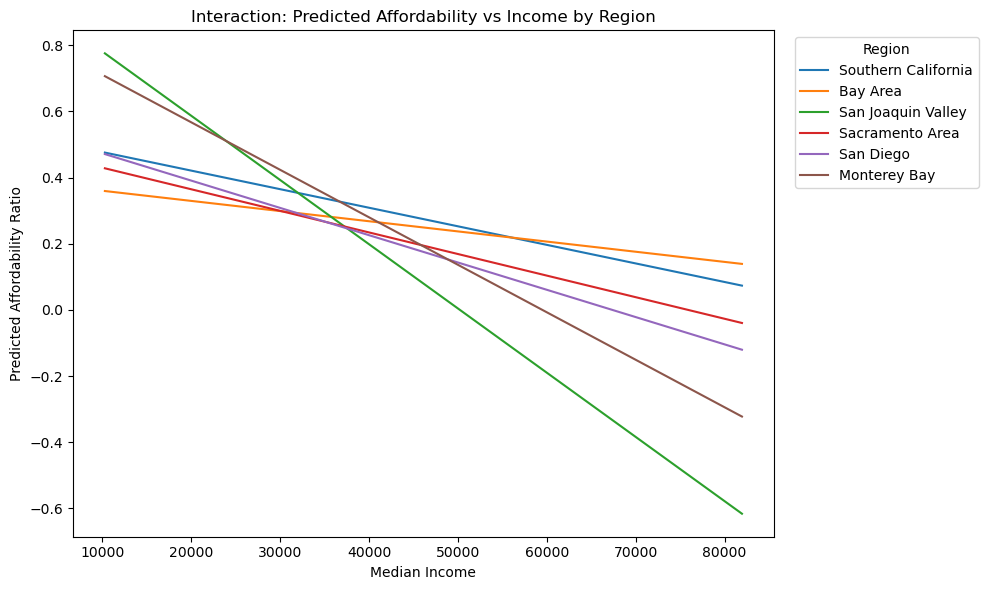

PosixPath('figures/rq3_income_region_interaction.png')

In [4]:
fig_path = FIG_DIR / "rq3_income_region_interaction.png"

plt.figure(figsize=(10, 6))
for r in top_regions:
    sub = pred_df[pred_df["region_name"] == r]
    plt.plot(sub["income_c"] + df_rq3_plot["median_income"].mean(), sub["pred_affordability"], label=r)

plt.xlabel("Median Income")
plt.ylabel("Predicted Affordability Ratio")
plt.title("Interaction: Predicted Affordability vs Income by Region")
plt.legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig(fig_path, dpi=150)
plt.show()

fig_path
